In [1]:
site_n = 6  # Default site to process; replaced by sites from execute_notebooks notebook

In [2]:
# Contents/user notes

In [3]:
# ## * **1** User to input primary variables
#     * a) Define geographic variables *(primarily referenced to single closest tide post. Sub-polygon splitting, where user defined bounding box crosses multiple voronoi cells/tide posts to be added later)*
#     * b) User to define where their outputs are to be saved
    
#     NOTE To do: update co-ordinates to handle multiple tide-posts when selecting boundary box lat's and long's
    
    
# ## * **2** Generate global model and observation datasets for given location, for 1986 to present *(Automate all processeing in the notebook back-end. Show only the plot of global values. Save csv files of model and observations, as well as the plot to user designated folder)*
#     * a) Import all modules
#     * b) Determine modelled tide heights and dates
#     * c) Find all satellite observations
#     * d) Tag all observations as ebbing or flowing
#     * e) Save modelled values and observations as separate dataframes
#     * f) Plot all available information for a given site (model and obs). Show every 10th percentile of the observed tide range with a labelled horizontal line
    
    
# ## * **3** User to define secondary variables
#     * Complete time range of interest *(epochs and tidal percentile ranges calculated from this time range)*
#     * Epoch length *(How many of years of data to include in every composite)*
#     * Tidal range of interest *(Composites are produced for observations between these values/percentiles)*
#         * Upper percentile of tidal range
#         * Lower percentile of tidal range
#     * Tidal stages of interest
#         * Ebb
#         * Flow
#         * Peak high
#         * Peak low
#         * All
        
        
# ## * **4** Generate dataset of interest and plot composites and data summary with interactive functionality (*Move all code to notebook back end. Show only the composite images and data summary plot. Note the saved file names and storage location in the output cell*)
#     * If the user-defined complete time range differs from default (1986 - present) then generate the statistical baseline from the user-defined time range to draw the tidal percentiles from
#     * Sub-sample the observations to generate data for the tidal stages of interest, in the defined percentile range, for each epoch
#     * Plot composite images of each epoch
#     * Plot the data summary, with colour coding to show which observations were input into each composite. Include interactive functionality for investigation of individual input images.
#     * Save each plot and a csv file with the input data to the users designated storage space
    
    
# ## * **5** Allow users to explore individual scenes via interactive plot
#     * Have a non-code cell, instrucing users how to use the interactive plot *i.e. Using the mouse, click once on an observation on the plot then run the cell/s below. The observation recorded closest in time to the mouse click will be returned below*
#     * Bring in the code to return the closest image *(Hide in the notebook backend. Output the scene only, noting the time/date it was captured and where the image has been saved to)*
    
# **Notebook end**

In [4]:
# Import all modules
print ("1a) Import modules")

%pylab notebook

import datacube
import xarray as xr
import matplotlib.dates
import fiona
import shapely
import shapely.geometry
import rasterio
import rasterio.features
import matplotlib.pyplot as plt
import numpy as np
import itertools
import otps
import sys
import pandas as pd
import matplotlib as mpl

from __future__ import print_function
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.helpers import ga_pq_fuser
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, mapping, shape
from fiona import collection
from matplotlib.gridspec import GridSpec
from datacube.utils import geometry
from datacube.api.grid_workflow import GridWorkflow
from datacube.api.query import query_group_by
from otps import TimePoint, predict_tide
from dateutil.relativedelta import relativedelta
from operator import itemgetter
from datetime import date, datetime, timedelta
from matplotlib import cm
from datetime import datetime as datetime
from IPython.display import display

dc = datacube.Datacube(app='Tide selection Hovmoller')

print ('1a) Complete: modules imported ' +str(datetime.now()))

1a) Import modules
Populating the interactive namespace from numpy and matplotlib
1a) Complete: modules imported 2018-02-06 12:52:51.981712


# User to define primary variables - Location

In [5]:
# Geographic variables##



# NOTE use only lat/long/tide post OR filepath and polygon ID. Comment out what you don't need.
# ----------------------------------------------------------------------------
#     1ai) Lat/long bounding box
# LOC = 'botanybay'
# lon_range = '(151.15, 151.24)'
# lat_range = '(-33.94, -33.99)'

# ----------------------------------------------------------------------------
#     Import from points shapefile
vec_fname = 'raw_data/item_std_change_sites.shp'

# Extract data from shapefile and buffer points
with fiona.open(vec_fname) as src:
    lon_point, lat_point = src[site_n]['geometry']['coordinates'] 
    lon_range = str((round(lon_point - 0.04, 3), round(lon_point + 0.04, 3)))
    lat_range = str((round(lat_point - 0.04, 3), round(lat_point + 0.04, 3)))
    LOC = src[site_n]['properties']['loc']

# ----------------------------------------------------------------------------
#     1aii) Tide post
# lon = 151.23
# lat = -22.99
# LOC = 'Daly' #Include a loction name for area of interest to simplify file naming
# ----------------------------------------------------------------------------
#     # 1b) polygon
# 
# #'/g/data/r78/cp7765/agdc_tidal/GA_tidal_model.shp'
# #u46/users/bxb547/otps/vector_data/GA_tidal_model.shp'
# polygon = 216 # 306 polygons around Australian coastline. Insert Id for polygon of interest
# lon = 123.29  # polygon centroid longitude. Source from attribute_table.csv in g/data/r78/cp7765/agdc_tidal
# lat = -16.79  # polygon centroid latitude. Source from attribute_table.csv in g/data/r78/cp7765/agdc_tidal
# lon_range = (lon-0.05, lon + 0.05)
# lat_range = (lat+0.05, lat - 0.05)
# LOC = str(polygon) #Include a loction name for area of interest to simplify file naming
# ----------------------------------------------------------------------------
   #1c) shapefile
# vec_fname = '/g/data/r78/rt1527/intertidal/line_shape.shp'  #upload your shapefile
# site_name = (vec_fname.split('/')[-1]).split('.')[0]
#                                             ##Daly_.shp
#                                             ##Darwin_.shp
#                                             #Flinders_.shp
#                                             ##Gilbert_.shp
#                                             #Keep_.shp
#                                             #Macarthur_.shp
#                                             #Roper_.shp

# LOC = str((vec_fname.split('/')[-1]).split('_')[-2]) 
                            
# with fiona.open(vec_fname) as src:
#     geom = shape(src[0]['geometry'])

# lon_range = (geom.bounds[0], geom.bounds[2])
# lat_range = (geom.bounds[1], geom.bounds[3])

# lon_range = str(lon_range)
# lat_range = str(lat_range)
# ----------------------------------------------------------------------------
print ("Variables accepted for", LOC, lon_range, "and", lat_range)

# Issues with Manningpoint -31.8801395883, 152.686652871

Variables accepted for botanybay (151.155, 151.235) and (-34.001, -33.921)


# Create output directories

In [6]:
# Create figure and output_data directories
import os
os.makedirs("figures/" + str(LOC), exist_ok=True)
os.makedirs("output_data/" + str(LOC), exist_ok=True)
print("figures/" + str(LOC))

figures/botanybay


## Plot ITEM v2 confidence layer and export to image file

In [7]:
% pylab notebook
# %matplotlib inline

# Load ITEM v2 confidence layer
item_data = dc.load(product='item_v2_conf', 
               x = eval(str(lon_range)), 
               y = eval(str(lat_range)))

print(item_data)


Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape', 'datetime', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<xarray.Dataset>
Dimensions:  (time: 1, x: 345, y: 398)
Coordinates:
  * time     (time) datetime64[ns] 2001-06-01T23:59:59.500000
  * y        (y) float64 -3.834e+06 -3.834e+06 -3.834e+06 -3.834e+06 ...
  * x        (x) float64 1.754e+06 1.754e+06 1.754e+06 1.754e+06 1.754e+06 ...
Data variables:
    stddev   (time, y, x) float32 0.110095 0.116697 0.142561 0.138215 ...
Attributes:
    crs:      EPSG:3577


(398, 345)


<IPython.core.display.Javascript object>


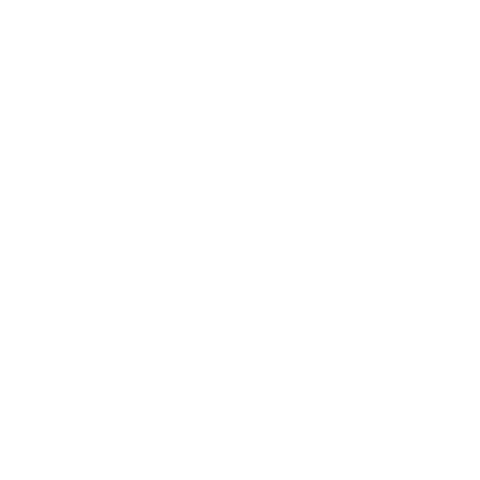

In [8]:
# Give warning if below 256 pixels
print(item_data.stddev[0,:,:].shape)
if any(list((i < 256 for i in item_data.stddev[0,:,:].shape))):
    print('WARNING: raster dimensions < 256 pixels will cause geotiff writing to fail')

# Set up color scheme
conf_cmap = plt.cm.get_cmap('YlOrRd')
conf_bounds = [0, 0.075, 0.15, 0.22, 0.3, 1]
conf_norm = mpl.colors.BoundaryNorm(conf_bounds, conf_cmap.N)

# Plot ITEM confidence, save to file and show
conf_fig = plt.figure(figsize=(6,6))
gs1 = GridSpec(1, 1)
ax1 = conf_fig.add_subplot(gs1[0])  
plt.imshow(item_data.stddev[0,:,:], cmap = conf_cmap, norm = conf_norm, interpolation='nearest')
ax1.axis('off')
plt.title('ITEM v2 confidence')
# plt.colorbar(fraction=0.0345, pad=0.04)
savefig('figures/' + str(LOC) + '/ITEMv2_conf_' + str(LOC) + '_lat_range_' + str(lat_range) + \
        '_lon_range_' + str(lon_range) + '.png', dpi = 300) 
plt.show()  

# Generate global modelled and observed datasets for location, from 1986 to present

In [9]:
from datetime import datetime as datetime

#    User only sees data summary plot in their output cell

#Run for entire archive of datasets to extract observed tide height on those UTC time

native_path = '/g/data/r78/intertidal/GA_native_tidal_model.shp'

#these are the datasets we are using observations from for global values
#products = ['ls5_pq_albers', 'ls8_pq_albers'] # these are the datasets we are using observations from when time_period begins after 2003
products = ['ls5_pq_albers', 'ls7_pq_albers', 'ls8_pq_albers'] 

time_period=('1986-01-01', '2018-01-01') # this is a global time range. Global=('1986-01-01', '2018-01-01')
LS7_SLC_DT = datetime.strptime("2003-05-01", "%Y-%m-%d") ###THIS CHANGE FILTERS OUT STRIPEY LS7 DATASETS
# LS7_SLC_DT = datetime.strptime("2020-05-01", "%Y-%m-%d") ###THIS CHANGE INCLUDES ALL LS7 DATASETS

points = list()
lon1 = eval(lon_range)[0]
lon2 = eval(lon_range)[1]
lat1 = eval(lat_range)[0]
lat2 = eval(lat_range)[1]

point1 = Point(lon1,lat1)
point2 = Point(lon1,lat2)
point3 = Point(lon2,lat1)
point4 = Point(lon2,lat2)

ID = 0
lon = 0
lat = 0
tp = list()
all_times_dict = dict()

# For each tidal model polygon, test if point is within polygon
def search_point(point=point1):
    with fiona.open(native_path) as Input:
    #crs = geometry.CRS(str(Input.crs_wkt))
        for feature in Input:
            ID = feature['properties']['ID']            
            if feature['geometry']['type'] == "MultiPolygon":
            #polygon = MultiPolygon(feature['geometry'])               
                if point.within(shape(feature['geometry'])):
                    print ("Found feature in " + str(ID))
                    lon = feature['properties']['lon']
                    lat = feature['properties']['lat']
                    return ID, lon, lat
            else: 
                polygon = Polygon(feature['geometry']['coordinates'][0])
            
            if polygon.contains(point): 
                lon = feature['properties']['lon']
                lat = feature['properties']['lat']
                return ID, lon, lat
        return 0
    
def get_dataset_dates(lon, lat):
    dc=datacube.Datacube(app='test')
    all_time = list()
    for source in products:
        time_range = time_period
        if source == 'ls7_pq_albers' and (datetime.strptime(time_range[0], "%Y-%m-%d") > LS7_SLC_DT):
            continue
        time_range = (time_range[0], LS7_SLC_DT) if source == 'ls7_pq_albers' and \
                     (datetime.strptime(time_range[1], "%Y-%m-%d")  > LS7_SLC_DT) else time_period
        print ("finding datasets for " + source + " in " + str(time_range))
        ds = dc.find_datasets(product=source, time=time_range, x = eval(lon_range), y= eval(lat_range))
        group_by = query_group_by(group_by='solar_day')
        sources = dc.group_datasets(ds, group_by)
        if len(ds) > 0 :
            all_time = all_time + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
            all_time = sorted(all_time)    
 
    print ("tide post selected " + str(lon) + str(lat))
    return all_time
#     for dt in all_times:
#         tp.append(TimePoint(lon, lat, dt))
#     tides = predict_tide(tp)
#     tide_dic = dict()

#     for tt in tides:
#         tide_dic[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m

#     tide_data = sorted(tide_dic.items(), key=lambda x: x[1])
#     print (sorted([[x[0].strftime('%Y-%m-%d'), x[1]] for x in tide_data]))
#     return tide_data


if search_point(point1)[0] > 0 and search_point(point2)[0] > 0 and search_point(point3)[0] > 0 : 
    ID, lon, lat = search_point(point4)
    if ID > 0:
        print ("coordinates are within polygon " + str(ID))
        print ("tide post found in " + str(lon) + "," + str(lat))
        all_times_dict['date_range'] = get_dataset_dates(lon, lat)
        polygon=ID
        #print (polygon)
            
    else:
        print ("Not allowed for multiple polygons. Please refer to GA tidal model shape file")
else :
    print ("Not allowed for multiple polygons. Please refer to GA tidal model shape file")   


print ("Co-ordinate attribution is complete")


# 2b) Determine all modelled tide heights and dates for global time range

def date_range(start_date, end_date, increment, period):
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

start = datetime.strptime(time_period[0] + " 00:00:00", "%Y-%m-%d %H:%M:%S")
end = datetime.strptime(time_period[1] + " 00:00:00", "%Y-%m-%d %H:%M:%S")

tp_model = list()
tide_det = list()
print ("2b) Start: determine all modelled tide heights and dates for global time range for lon "+ str(lon) +', lat ' + \
str(lat) + ", " + str(datetime.now()))
#print ("starting", str(datetime.now()) + " for lon " + str(lon) +', lat ' + str(lat))
for string_date in date_range(start, end, 1, 'hours'):
    dt_model = datetime.strptime(str(string_date), "%Y-%m-%d %H:%M:%S")
    tp_model.append(TimePoint(lon, lat, dt_model))                    

#print ("added to the list", str(datetime.now()))

tides_model = predict_tide(tp_model)
#print ("received from predict tides", str(datetime.now()))

for tt in tides_model:
    tide_det.append([tt.timepoint.timestamp.isoformat()[0:10], tt.tide_m])
#print ("Complete: modelling of date and tide height for " + LOC + " between 1986 and present", str(datetime.now()))
print ("2b) Complete: " + str(datetime.now()))

# 2c) Find all satellite observations for global time range

print ("2c) Start: Find all satellite observations for global time range")

    #Note: the products definition has been moved upwards into the section (2aa) defining a user-defined bounding box
dc=datacube.Datacube(app='test') # is this line required?

tp=list()

# filepath=''
# #filepath = '/g/data/r78/cp7765/agdc_tidal/GA_tidal_model.shp'

# try:
#     all_times = list()
#     with fiona.open(filepath) as Input:
#         crs = geometry.CRS(str(Input.crs_wkt))
#         for feature in Input:
#             lon = feature['properties']['lon']
#             lat = feature['properties']['lat']
#             Id = feature['properties']['ID']
            
            
#             if Id == polygon:
#                 print ("Confirm co-ords and tide post " + str(lon)+", " + str(lat)+", " + str(Id))
#                 first_geometry = feature['geometry']
#                 geom = geometry.Geometry(first_geometry, crs=crs)
                                
#                 for source in products:                 
#                     time_range = ('1986-01-01', '2003-05-01') if source == 'ls7_pq_albers' else time_period ## this line\
#                     ## requires editing with a date exception for the ls7 time range, dependent on the time_period. e.g\
#                     ## if time_period = 2010 to 2017, the global data summary plot has issues plotting.
#                     ds = dc.find_datasets(product=source, time=time_range, geopolygon=geom, group_by='solar_day')
#                     group_by = query_group_by(group_by='solar_day')
#                     sources = dc.group_datasets(ds, group_by)
#                     if len(ds) > 0 :
#                         all_times = all_times + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
#                     all_times = sorted(all_times)            
#                 break
# except IOError as e:
#     print ("Polygon File not found ")
                
## For use when co-ordinates are lat/long bounding box rather than ITEM polygons 

all_times = list()

if len(lon_range) > 0:
    for source in products:
        time_range = ('1986-01-01', '2003-05-01') if source == 'ls7_pq_albers' else time_period
        print ("finding datasets for " + source + " in " + str(time_range))
        ds = dc.find_datasets(product=source, time=time_range, x = eval(str(lon_range)), y= eval(str(lat_range)))
        group_by = query_group_by(group_by='solar_day')
        sources = dc.group_datasets(ds, group_by)
        if len(ds) > 0 :
            all_times = all_times + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
            all_times = sorted(all_times)
    

#print ("tide post selected " + str(lon) + str(lat))
print ("Attributing tide height to satellite observations")
all_times= all_times_dict['date_range']

for dt in all_times:
    tp.append(TimePoint(lon, lat, dt))
tides = predict_tide(tp)
tide_dic = dict()

for tt in tides:
    tide_dic[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m


tide_data = sorted(tide_dic.items(), key=lambda x: x[1])

#print (sorted([[x[0].strftime('%Y-%m-%d %H:%M:%S'), x[1]] for x in tide_data]))
print ("2c) Complete: compiled and attributed tide height to all satellite observations between 1986 and the present for\
" + LOC + str(datetime.now()))

# 2d) Append ebb, flow, peak high and peak low to observations
print ("2d) Start: append ebb, flow, peak high and peak low to observations")

# Create dataframe of tide heights, indexed by date/time (UTC)

df1_data = {'Tide_height': list((x[1] for x in sorted(tide_data)))}
df1_index = list(x[0].strftime("%Y-%m-%dT%H:%M:%S") for x in sorted (tide_data))
df1 = pd.DataFrame(df1_data, df1_index)

# Using OTPS model, determine tidal stage of each observation
# Ebb/flow is determined by tide height 15 minutes before and after each observation

stagecalc_list=list()
tp_ebbflow = list()
tide_dict_ebbflow = dict()

mnt=timedelta(minutes=15)

for dt in df1_index:
    dt = datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
    stagecalc_list.append(dt-mnt)
    stagecalc_list.append(dt)
    stagecalc_list.append(dt+mnt)
    
for dt in stagecalc_list:
    tp_ebbflow.append(TimePoint(lon, lat, dt))
    
tide_stage = predict_tide(tp_ebbflow)

for tt in tide_stage:
    tide_dict_ebbflow[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m 
    
tmp_lt = sorted(tide_dict_ebbflow.items(), key=lambda x: x[0])

tmp_lt = [[tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"), 'ph'] \
         if tmp_lt[i][1] < tmp_lt[i+1][1] and tmp_lt[i+2][1] <  tmp_lt[i+1][1]  else \
        [tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"), 'pl'] if tmp_lt[i][1] > tmp_lt[i+1][1] and \
        tmp_lt[i+2][1] >  tmp_lt[i+1][1]  else [tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"),'f'] \
        if tmp_lt[i][1] < tmp_lt[i+2][1] else [tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"),'e'] \
         for i in range(0, len(tmp_lt), 3)]

ebb_flow = str([tt for tt in tmp_lt ])   
key = set(e[0].strftime("%Y-%m-%dT%H:%M:%S") for e in tide_data)
ebb_flow_tides = [ff for ff in eval(ebb_flow) if ff[0] in key]

# Add ebb/flow tide stages to the tide height dictionary, in preparation for storage in dataframe

df1_tidestage = {'Tide_stage': list((x[1] for x in sorted(ebb_flow_tides)))}
df1_data.update(df1_tidestage)

print ('2d) Complete: tidal stage attributed to satellite observations ' + str(datetime.now()))

# 2e) Save modelled and observed datasets into separate dataframes, in preparation to plot
print ("2e) Start: plot preparation - create dataframes for modelled and observed datasets")

# Observations: date, tide height, tide stage (Update index to show dates only)
df1_index = list(x[0].strftime('%Y-%m-%d') for x in sorted (tide_data))

df1_obs = pd.DataFrame(df1_data, index=df1_index)
# print (df1_obs.head(20))

# Model: date, tide height
df2_data = {'Model_height': list(x[1] for x in sorted(tide_det))}
df2_index = list(x[0] for x in sorted (tide_det))
df2_model = pd.DataFrame(df2_data, index=df2_index)
#print (df2_model.head(10))

print ('2e) Complete ' + str(datetime.now()))

coordinates are within polygon 1
tide post found in 118.96,-19.95
finding datasets for ls5_pq_albers in ('1986-01-01', '2018-01-01')
finding datasets for ls7_pq_albers in ('1986-01-01', datetime.datetime(2003, 5, 1, 0, 0))
finding datasets for ls8_pq_albers in ('1986-01-01', '2018-01-01')
tide post selected 118.96-19.95
Co-ordinate attribution is complete
2b) Start: determine all modelled tide heights and dates for global time range for lon 118.96, lat -19.95, 2018-02-06 12:53:16.912550
2b) Complete: 2018-02-06 12:54:01.597393
2c) Start: Find all satellite observations for global time range
finding datasets for ls5_pq_albers in ('1986-01-01', '2018-01-01')
finding datasets for ls7_pq_albers in ('1986-01-01', '2003-05-01')
finding datasets for ls8_pq_albers in ('1986-01-01', '2018-01-01')
Attributing tide height to satellite observations
2c) Complete: compiled and attributed tide height to all satellite observations between 1986 and the present forbotanybay2018-02-06 12:54:10.757857
2d)

##### Plot modelled tide heights against observations
No user input required. Edit lines 21 to 44 to plot observations sorted by tidal stage.

Populating the interactive namespace from numpy and matplotlib
2f) Start: plot global data summary for botanybay


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'source']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


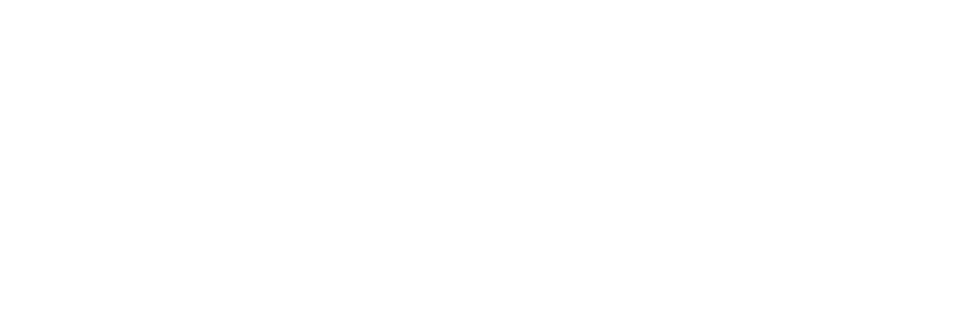

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [10]:
% pylab notebook
# 2f) Plot global modelled tide heights and dates against all observations for given location
print ("2f) Start: plot global data summary for " + str(LOC))

# Plot setup
fig = plt.figure(figsize=(12,4))
mpl.rcParams['agg.path.chunksize'] = 10000
plt.ylabel('Tide height (m)')
#fig.canvas.mpl_connect('button_press_event', callback)
#plt.legend() #(bbox_to_anchor=(0,-0.3), loc='center left')
plt.title('Available data for ' + LOC)

# Data series
# Prepare x-axis
obs_index = pd.DatetimeIndex(df1_index)
obs_index = obs_index.to_datetime()
obs_index = np.array(obs_index.to_pydatetime(), dtype = numpy.datetime64)
# Plot observations
scatter(obs_index, df1_obs.Tide_height, s=20, color='black', marker='o', zorder=2, label = 'observations') # All observations

# # Plot tide stages
# df_e = df1_obs.query('Tide_stage == "e"')
# df_e_index = pd.DatetimeIndex(df_e.index)
# df_e_index = df_e_index.to_datetime()
# df_e_index = np.array(df_e_index.to_pydatetime(), dtype = numpy.datetime64)
# scatter(df_e_index, df_e.Tide_height, s=20, color='gray', marker='o', edgecolors='black', zorder=2, label = 'Obs. ebb tide')

# df_f = df1_obs.query('Tide_stage == "f"')
# df_f_index = pd.DatetimeIndex(df_f.index)
# df_f_index = df_f_index.to_datetime()
# df_f_index = np.array(df_f_index.to_pydatetime(), dtype = numpy.datetime64)
# scatter(df_f_index, df_f.Tide_height, s=20, color='black', marker='o', zorder=3, label = 'Obs. flow tide')

# df_ph = df1_obs.query('Tide_stage == "ph"')
# df_ph_index = pd.DatetimeIndex(df_ph.index)
# df_ph_index = df_ph_index.to_datetime()
# df_ph_index = np.array(df_ph_index.to_pydatetime(), dtype = numpy.datetime64)
# scatter(df_ph_index, df_ph.Tide_height, s=20, edgecolors='black', color='white', marker='D', zorder=4, label = 'Obs. peak high tide')

# df_pl = df1_obs.query('Tide_stage == "pl"')
# df_pl_index = pd.DatetimeIndex(df_pl.index)
# df_pl_index = df_pl_index.to_datetime()
# df_pl_index = np.array(df_pl_index.to_pydatetime(), dtype = numpy.datetime64)
# scatter(df_pl_index, df_pl.Tide_height, s=35, edgecolors='black', color='white', marker='*', zorder=5, label = 'Obs. peak low tide')


## Model values
# Prepare x-axis
model_index = pd.DatetimeIndex(df2_index)
model_index = model_index.to_datetime()
model_index = np.array(model_index.to_pydatetime(), dtype = numpy.datetime64)
# Plot model values
plot(model_index, df2_model.Model_height, color='lightgray', linewidth=0.5, zorder=1, label = 'OTPS model')

## Percentile ranges (from observations)
# Determine tide height at every 10th percentile of the observed tide range to plot on global data fig
sub_data = [[x[0], x[1]] for x  in tide_data] 
min_height=sub_data[0][1]
max_height=sub_data[-1][1]
dr = float(max_height)-float(min_height) # Max tidal range

per10_list = []
for PERC in range(0,110,10):
    lmr = float(min_height) + dr*float(PERC)*0.01   # low tide max range
    #p#er10_dict=[PERC]
    per10_list.append([PERC, lmr]) 
    
per10_data = {'PERC_tide_height': list(x[1] for x in sorted(per10_list))}
per10_index = list(x[0] for x in sorted(per10_list))
df_per10 = pd.DataFrame(per10_data, per10_index)


for i in per10_list:
    plot([model_index[0], model_index[-1]], [df_per10.PERC_tide_height[i],df_per10.PERC_tide_height[i]], 'black', \
         linewidth=0.4)# , label= str(a) + 'th %ile of obs')
    plt.text(model_index[-1] + 100, i[1] - 0.025, str(i[0])+'th %ile', fontsize=8)

plot([(model_index[0]), (model_index[-1]+1000)], [(df_per10.PERC_tide_height[0] - 0.3),df_per10.PERC_tide_height[0]],\
     'none', linewidth=0)# , label= str(a) + 'th %ile of obs')
        
plt.legend(loc='lower center', prop={'size':8}, ncol=5, fancybox=True, framealpha=0.2) #, bbox_to_anchor=(0,-0.1))
plt.savefig('figures/' + str(LOC) + '/Global_data_summary_for_' + str(LOC) + '_lat_range_' + str(lat_range) +"_lon_range_"+ str(lon_range)\
            +'_.jpeg')
plt.show()

# Composite generation

## Define composite inputs and generate datasets
User to define variables for composite generation
    Note: code has not yet been built to show composites based on tidal stage

In [11]:
# Define variables to generate composite imagery

# What is your total time period of interest?
time_range = ['1988-01-01', '2018-01-01']  # Default 1988 to present (whole archive). ('YYYY-MM-DD','YYYY-MM-DD') format

# How many years do you wish to view in each composite?
epoch = 5                               # Minimum is 1 year. Positive integers only.

# What is your tidal range of interest? Nominate the percentile range between which you wish to view composite imagery.
upper = 60 # Maximum range is 1-100
lower = 40  # Maximum range is 0-99

# # Which tidal stage/s would you like to include in your composites?
# all_stages = 'yes' # Default = yes
# ebb = '' # Default = no
# flow = '' # Default = no
# peak_high = '' # Default = no
# peak_low = '' # Default = no
#This variables are for GEOMEDIAN call

TIDE_POST = "--tide_post " + "'(" + str(lon) + "," + str(lat) + ")'"
EPOCH = "--epoch "+ str(epoch) #default epoch 2
DEB = "--debug"   # To get detail of date/time and tide heights
LS7FL="--ls7fl"  #To include LS7 datasets
ALL = "--all_value"
#YEAR="--year_range 1986-2017"
#YEAR = "--year_range " + time_range[0][:4] + '-' + time_range[1][:4]
YEAR = "--year_range " + time_range[0] + '_' + time_range[1]
HR = " --date_all_2 "  # This is to pass the tide date list
QT = "'"
LON = "--lon_range " + "'" + lon_range + "'"
LAT = "--lat_range " + "'" + lat_range + "'"
# season = "--season " + "'" + str(summer) + "'" 

# @click.option('--season', 'season', default='dummy', type=str, help='summer winter autumn spring')

print (YEAR, EPOCH, LON, LAT, TIDE_POST)

--year_range 1988-01-01_2018-01-01 --epoch 5 --lon_range '(151.155, 151.235)' --lat_range '(-34.001, -33.921)' --tide_post '(118.96,-19.95)'


Generate composite input datasets. No user input is required

In [12]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from math import ceil

# 4. Generate data sub-sets to produce composites and interactive data summary plot
# 4.1 Sub-sample global imagery for location from df1_obs to include only those defined by user in 'time_range'
## Save results into new df3_obs_time_range
df3_obs_time_range = df1_obs.loc[time_range[0]: time_range[1]]

# 4.21 Sub-sample df3_time_range to include only observations located between 'upper' and 'lower' tidal range
## Save results into new df4_obs_tide_range

#Covert percentile request from 'upper' and 'lower' into value for tide height
# 4.4 Generate geomedian values for the bands in the observations of each epoch (from dataframe_collection dict)
# Obs_tide_min=df3_obs_time_range.Tide_height.min() ######## USE WITH A TIME_RANGE SPECIFIC BASELINE (perc stats from time_range dataset)
# Obs_tide_max=df3_obs_time_range.Tide_height.max() ######## USE WITH A TIME_RANGE SPECIFIC BASELINE (perc stats from time_range dataset)
Obs_tide_min=df1_obs.Tide_height.min() ######## USE WITH A GLOBAL BASELINE (perc stats from global dataset)
Obs_tide_max=df1_obs.Tide_height.max() ######## USE WITH A GLOBAL BASELINE (perc stats from global dataset)

tide_range=Obs_tide_max - Obs_tide_min
lower_value = ceil((Obs_tide_min + (tide_range*lower*0.01))*1000)/1000
print ('Tide height at ' +str(lower)+ ' percentile: ' + str(lower_value)+' m')

upper_value = ceil((Obs_tide_min + (tide_range*upper*0.01))*1000)/1000
print ('Tide height at ' + str(upper)+ ' percentile: ' + str(upper_value) + ' m')

df4_obs_tide_range = df3_obs_time_range[(df3_obs_time_range['Tide_height']>=lower_value) & \
                                         (upper_value>=df3_obs_time_range['Tide_height'])]

# 4.3 Slice dataset into epochs in preparation to plot

START = datetime.strptime(time_range[0], '%Y-%m-%d')
END = datetime.strptime(time_range[1], '%Y-%m-%d')

obs_tide_range_epoch = {}
while START < END:
     st = datetime.strftime(START, "%Y-%m-%d")
     en = START + relativedelta(years=(epoch))
     #en = en - relativedelta(days=1)
     en = datetime.strftime(en, "%Y-%m-%d")
     #print ("doing for epoch" + str(st) + "_" +  str(en))
     epoch_data = str(st) + "_" +  str(en)
     obs_tide_range_epoch[epoch_data] = df4_obs_tide_range.loc[st:en]
     START = START + relativedelta(years=epoch)
        
START = datetime.strptime(time_range[0], '%Y-%m-%d')
END = datetime.strptime(time_range[1], '%Y-%m-%d')        
        
all_obs_tide_range_epoch = {}
while START < END:
     st = datetime.strftime(START, "%Y-%m-%d")
     en = START + relativedelta(years=(epoch))
     #en = en - relativedelta(days=1)
     en = datetime.strftime(en, "%Y-%m-%d")
     #print ("doing for epoch" + str(st) + "_" +  str(en))
     epoch_data = str(st) + "_" +  str(en)
     all_obs_tide_range_epoch[epoch_data] = df1_obs.loc[st:en]
     START = START + relativedelta(years=epoch) 

START = datetime.strptime(time_range[0], '%Y-%m-%d')
END = datetime.strptime(time_range[1], '%Y-%m-%d')        
        
model_epoch = {}
while START < END:
     st = datetime.strftime(START, "%Y-%m-%d")
     en = START + relativedelta(years=(epoch))
     #en = en - relativedelta(days=1)
     en = datetime.strftime(en, "%Y-%m-%d")
     #print ("doing for epoch" + str(st) + "_" +  str(en))
     epoch_data = str(st) + "_" +  str(en)
#      epoch_data = [st:en:1]
     model_epoch[epoch_data] = df2_model.loc[st:en]
     START = START + relativedelta(years=epoch)

LIST = (sorted(model_epoch.keys())) 

# 4.5 Plot composites
# For each epoch, plot paired images of composite next to data summary
tide_list = list()
for ls1, ls2 in zip(df4_obs_tide_range.index.tolist(),df4_obs_tide_range['Tide_height'].tolist()):
    tide_list.append((ls1,ls2))


tide_list = sorted(tide_list)
print ("sorted date tide list to pass to geomedian " + str(len(tide_list)))

tide_list = ['"{0}, {1}"'.format(w[0], w[1]) for w in tide_list]
tide_list = '{0}'.format(', '.join(tide_list))
print ( LON, LAT, YEAR, HR, EPOCH, DEB)

% pwd
%run inter_tidal_wf.py $LON $LAT $YEAR $HR $QT$tide_list$QT $EPOCH $DEB $ALL

Tide height at 40 percentile: -1.397 m
Tide height at 60 percentile: -0.392 m
sorted date tide list to pass to geomedian 85
--lon_range '(151.155, 151.235)' --lat_range '(-34.001, -33.921)' --year_range 1988-01-01_2018-01-01  --date_all_2  --epoch 5 --debug
Input date range 1988-01-01_2018-01-01
running task for epoch 1988-01-01 TO 1993-01-01 on percentile 10 tide post  for lon/lat range (151.155, 151.235)(-34.001, -33.921) epoch 5
 doing for sensor ls5_nbar_albers


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:272: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if st == 'ls5_nbar_albers' and len(pq) == 0:


 doing for sensor ls7_nbar_albers
 doing for sensor ls8_nbar_albers
tide list 
[('1992-07-22', ' -0.432'), ('1989-01-19', ' -0.459'), ('1988-05-08', ' -0.51'), ('1992-07-06', ' -0.52'), ('1990-09-03', ' -0.554'), ('1988-01-17', ' -0.642'), ('1990-12-24', ' -0.72'), ('1990-12-08', ' -0.765'), ('1991-09-22', ' -0.813'), ('1992-01-12', ' -0.862'), ('1991-12-27', ' -0.923'), ('1989-11-19', ' -0.935'), ('1991-03-14', ' -1.06'), ('1992-10-10', ' -1.096'), ('1988-04-22', ' -1.221'), ('1988-08-12', ' -1.301')]

 loaded nbar data 12:57:14.887426
creating GEOMEDIAN for epoch 1988-01-01_1993-01-0112:57:14.931172
running task for epoch 1993-01-01 TO 1998-01-01 on percentile 10 tide post  for lon/lat range (151.155, 151.235)(-34.001, -33.921) epoch 5
 doing for sensor ls5_nbar_albers


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:272: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if st == 'ls5_nbar_albers' and len(pq) == 0:


 doing for sensor ls7_nbar_albers
 doing for sensor ls8_nbar_albers
tide list 
[('1995-03-09', ' -0.414'), ('1993-08-10', ' -0.424'), ('1994-02-18', ' -0.718'), ('1994-05-09', ' -0.758'), ('1993-04-20', ' -0.766'), ('1993-07-25', ' -0.787'), ('1993-01-30', ' -0.832'), ('1997-07-04', ' -0.886'), ('1994-08-13', ' -0.972'), ('1995-05-28', ' -0.981'), ('1993-01-14', ' -1.085'), ('1996-03-11', ' -1.192'), ('1995-08-16', ' -1.225'), ('1995-02-21', ' -1.235'), ('1993-10-29', ' -1.272'), ('1997-03-30', ' -1.348')]

 loaded nbar data 13:01:30.134566
creating GEOMEDIAN for epoch 1993-01-01_1998-01-0113:01:30.178182
running task for epoch 1998-01-01 TO 2003-01-01 on percentile 10 tide post  for lon/lat range (151.155, 151.235)(-34.001, -33.921) epoch 5
 doing for sensor ls5_nbar_albers


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:272: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if st == 'ls5_nbar_albers' and len(pq) == 0:


 doing for sensor ls7_nbar_albers


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:275: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if nbar_data is not None and st == 'ls7_nbar_albers' and len(pq) == 0:


 doing for sensor ls8_nbar_albers
tide list 
[('2001-03-17', ' -0.434'), ('2000-05-17', ' -0.449'), ('1999-01-15', ' -0.514'), ('2000-02-27', ' -0.598'), ('2001-06-21', ' -0.649'), ('2000-06-02', ' -0.703'), ('2002-07-10', ' -0.75'), ('1998-07-23', ' -0.934'), ('1999-11-07', ' -0.992'), ('1999-08-11', ' -1.172'), ('2000-11-25', ' -1.174'), ('1998-04-18', ' -1.23'), ('1998-10-27', ' -1.37')]

 loaded nbar data 13:05:45.090830
creating GEOMEDIAN for epoch 1998-01-01_2003-01-0113:05:45.108458
running task for epoch 2003-01-01 TO 2008-01-01 on percentile 10 tide post  for lon/lat range (151.155, 151.235)(-34.001, -33.921) epoch 5
 doing for sensor ls5_nbar_albers


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:272: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if st == 'ls5_nbar_albers' and len(pq) == 0:


 doing for sensor ls7_nbar_albers
 epoch end date is reset for LS7 2003/05/01


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:275: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if nbar_data is not None and st == 'ls7_nbar_albers' and len(pq) == 0:


 doing for sensor ls8_nbar_albers
tide list 
[('2005-05-07', ' -0.394'), ('2004-01-29', ' -0.456'), ('2007-06-30', ' -0.475'), ('2007-03-26', ' -0.48'), ('2006-03-07', ' -0.622'), ('2006-12-04', ' -0.855'), ('2004-04-18', ' -0.952'), ('2004-05-04', ' -0.954'), ('2003-10-09', ' -1.2'), ('2004-07-07', ' -1.367'), ('2003-01-02', ' -1.393')]

 loaded nbar data 13:10:03.402257
creating GEOMEDIAN for epoch 2003-01-01_2008-01-0113:10:03.404199
running task for epoch 2008-01-01 TO 2013-01-01 on percentile 10 tide post  for lon/lat range (151.155, 151.235)(-34.001, -33.921) epoch 5
 doing for sensor ls5_nbar_albers
 epoch end date is reset for LS5 2011/12/01


/g/data1/r78/rt1527/intertidal/inter_tidal_wf.py:272: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  if st == 'ls5_nbar_albers' and len(pq) == 0:


 doing for sensor ls7_nbar_albers
LS7 post 2003 May data is not included
 doing for sensor ls8_nbar_albers
tide list 
[('2008-12-25', ' -0.467'), ('2011-08-28', ' -0.546'), ('2010-05-05', ' -0.676'), ('2011-02-01', ' -0.812'), ('2010-11-13', ' -0.82'), ('2009-04-16', ' -1.082'), ('2008-01-15', ' -1.109'), ('2009-01-10', ' -1.22'), ('2009-08-06', ' -1.357')]

 loaded nbar data 13:12:34.756885
creating GEOMEDIAN for epoch 2008-01-01_2013-01-0113:12:34.758404
running task for epoch 2013-01-01 TO 2018-01-01 on percentile 10 tide post  for lon/lat range (151.155, 151.235)(-34.001, -33.921) epoch 5
 doing for sensor ls5_nbar_albers
LS5 post 2011 Dec data is not exist
 doing for sensor ls7_nbar_albers
LS7 post 2003 May data is not included
 doing for sensor ls8_nbar_albers
tide list 
[('2016-03-02', ' -0.481'), ('2016-08-25', ' -0.533'), ('2014-04-14', ' -0.54'), ('2015-05-03', ' -0.549'), ('2016-05-21', ' -0.574'), ('2015-02-12', ' -0.62'), ('2017-06-09', ' -0.645'), ('2014-01-24', ' -0.674'

### Save the composite metadata to a csv file
If you require the metadata, de-comment this section (ctrl + ?). Confirm destination to save file. Edit path in 'outfile' if required. No other input is required

In [13]:
# Save the composite metadata to a csv file
outfile = open('output_data/' + str(LOC) + '/Composite_metadata_for_' + str(LOC) + '_lat_range_' + str(lat_range) +"_lon_range_"+ str(lon_range)+\
               "_epoch_"+str(epoch)+"_period_"+str(time_range)+'.csv', 'a') # file name, 'a'=append
for k,v in MY_EPOCH.items():
    # print (k, v)
    outfile.write("ALL%s,%s\n" % (k,v)) # Denotes the formatting of the file (key, values etc)

# Close file when done
outfile.close()


## Plot a data summary separated by epoch
No user inputs are required. Sometimes this cell needs to be run twice to view the plot.

Populating the interactive namespace from numpy and matplotlib
2f) Start: plot global data summary for botanybay


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cos', 'product', 'datetime', 'ceil', 'copy', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


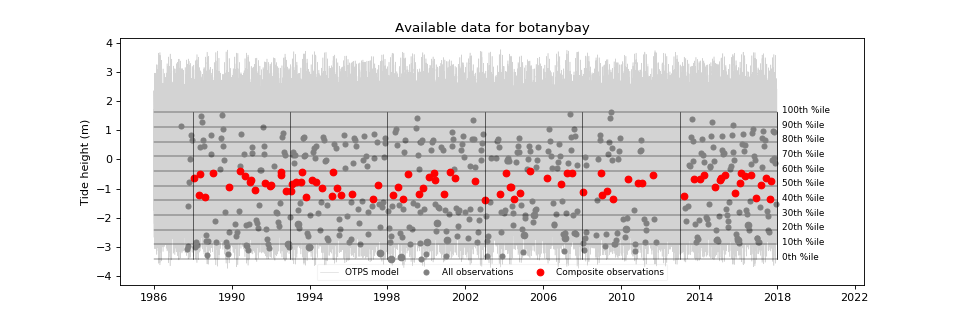

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [14]:
# PLOT A GLOBAL DATA SUMMARY SEPARATED BY EPOCH

% pylab notebook
# 2f) Plot global modelled tide heights and dates against all observations for given location
print ("2f) Start: plot global data summary for " + str(LOC))

# Plot setup
fig = plt.figure(figsize=(12,4))
mpl.rcParams['agg.path.chunksize'] = 10000
plt.ylabel('Tide height (m)')
#fig.canvas.mpl_connect('button_press_event', callback)
#plt.legend() #(bbox_to_anchor=(0,-0.3), loc='center left')
plt.title('Available data for ' + LOC)

# Data series
# Prepare x-axis
obs_index = pd.DatetimeIndex(df1_index)
obs_index = obs_index.to_datetime()
obs_index = np.array(obs_index.to_pydatetime(), dtype = numpy.datetime64)
# Plot observations
#scatter(obs_index, df1_obs.Tide_height, s=20, color='red', marker='o', zorder=2, label = 'observations') # All observations

# Plot tide stages
df_e = df1_obs.query('Tide_stage == "e"')
df_e_index = pd.DatetimeIndex(df_e.index)
df_e_index = df_e_index.to_datetime()
df_e_index = np.array(df_e_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_e_index, df_e.Tide_height, s=20, color='gray', marker='o', zorder=2, label = 'All observations')

df_f = df1_obs.query('Tide_stage == "f"')
df_f_index = pd.DatetimeIndex(df_f.index)
df_f_index = df_f_index.to_datetime()
df_f_index = np.array(df_f_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_f_index, df_f.Tide_height, s=20, color='gray', marker='o', zorder=3, label = None)#, label = 'Obs. flow tide')

df_ph = df1_obs.query('Tide_stage == "ph"')
df_ph_index = pd.DatetimeIndex(df_ph.index)
df_ph_index = df_ph_index.to_datetime()
df_ph_index = np.array(df_ph_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_ph_index, df_ph.Tide_height, s=20, color='gray', marker='o', zorder=4, label = None)#, label = 'Obs. peak high tide')

df_pl = df1_obs.query('Tide_stage == "pl"')
df_pl_index = pd.DatetimeIndex(df_pl.index)
df_pl_index = df_pl_index.to_datetime()
df_pl_index = np.array(df_pl_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_pl_index, df_pl.Tide_height, s=35, color='gray', marker='o', zorder=5, label = None)#, label = 'Obs. peak low tide')


# Plot observations used in plot
obstiderangeepoch_plotdates=np.array((pd.DatetimeIndex(df4_obs_tide_range.index).to_datetime()).\
                                     to_pydatetime(), dtype=numpy.datetime64)
scatter(obstiderangeepoch_plotdates, df4_obs_tide_range.Tide_height, marker="o", color="red", \
            zorder=8, label="Composite observations")
    
## Model values
# Prepare x-axis
model_index = pd.DatetimeIndex(df2_index)
model_index = model_index.to_datetime()
model_index = np.array(model_index.to_pydatetime(), dtype = numpy.datetime64)
# Plot model values
plot(model_index, df2_model.Model_height, color='lightgray', linewidth=0.5, zorder=1, label = 'OTPS model')

## Percentile ranges (from observations)
# Determine tide height at every 10th percentile of the observed tide range to plot on global data fig
sub_data = [[x[0], x[1]] for x  in tide_data] 
min_height=sub_data[0][1]
max_height=sub_data[-1][1]
dr = float(max_height)-float(min_height) # Max tidal range

per10_list = []
for PERC in range(0,110,10):
    lmr = float(min_height) + dr*float(PERC)*0.01   # low tide max range
    #p#er10_dict=[PERC]
    per10_list.append([PERC, lmr]) 
    
per10_data = {'PERC_tide_height': list(x[1] for x in sorted(per10_list))}
per10_index = list(x[0] for x in sorted(per10_list))
df_per10 = pd.DataFrame(per10_data, per10_index)


for i in per10_list:
    plot([model_index[0], model_index[-1]], [df_per10.PERC_tide_height[i],df_per10.PERC_tide_height[i]], 'black', \
         linewidth=0.4)# , label= str(a) + 'th %ile of obs')
    plt.text(model_index[-1] + 100, i[1] - 0.025, str(i[0])+'th %ile', fontsize=8)

#---------------------------------------------------------------------------------------------------------------
# PLOT THE EPOCHS ONTO THE GLOBAL SUMMARY

START = datetime.datetime.strptime(time_range[0] + 'T0:0:0', '%Y-%m-%dT%H:%M:%S')
END = datetime.datetime.strptime(time_range[1] + 'T0:0:0', '%Y-%m-%dT%H:%M:%S')    

epoch_list = []
epoch_list.append(datetime.datetime.strftime(START, "%Y-%m-%dT%H:%M:%S"))
while START < END:
     st = datetime.datetime.strftime(START, "%Y-%m-%dT%H:%M:%S")
     en = START + relativedelta(years=(epoch))
     #en = en - relativedelta(days=1)
     en = datetime.datetime.strftime(en, "%Y-%m-%dT%H:%M:%S")
     epoch_list.append(en)
     START = START + relativedelta(years=epoch)    
epoch_list.append(datetime.datetime.strftime(END, "%Y-%m-%dT%H:%M:%S"))

#Convert epochtime_end string to datetime format
epoch_list_datetime =[]
x=0
for b in epoch_list:
    epoch_list_datetime.append(datetime.datetime.strptime(epoch_list[x], "%Y-%m-%dT%H:%M:%S"))
    x=x+1
        
# Show each epoch
a=10
b=0
for date in epoch_list_datetime:
    plot([epoch_list_datetime[b], epoch_list_datetime[b]], [df_per10.PERC_tide_height[0], \
        df_per10.PERC_tide_height[100]], 'black',linewidth=0.5, zorder=a)
    a=a+1
    b=b+1    

# --------------------------------------------------------------------------------------------      

plot([(model_index[0]), (model_index[-1]+1000)], [(df_per10.PERC_tide_height[0] - 0.5),df_per10.PERC_tide_height[0]],\
     'none', linewidth=0)# , label= str(a) + 'th %ile of obs')
        
plt.legend(loc='lower center', prop={'size':8}, ncol=5, fancybox=True, framealpha=0.2) #, bbox_to_anchor=(0,-0.1))
savefig('figures/' + str(LOC) + '/Available data for ' + LOC + ' lat range ' + str(lat_range) +" lon range "+ str(lon_range)+ \
        ' global epoch summary ' + str(lower) + ' to ' + str(upper) + str(time_range) + ' perc_range.png')

## Plot composites for each epoch
This cell simultaneously visualises composites in either rgb or false colour (swir1, nir, green) and produces 6-band geotiff files of composites.

Note that the variable *false_col* has two versions. 
    If you want an rgb version of your composite, comment out lines 10 and 80. Edit line 116 to say "True colour" rather than 'false' in your saved png file name. 
    Alternately, if you want a false colour image, comment out lines 9 and 79, ensuring that line 116 will name your png file correctly.

Lines 22 to 63 are required to produce geotiff 6 band geotiff images of each composite. Comment out if not required.

If you would like to view your composite next to its data input plot, de-comment lines 69, 74, 87-111, comment out line 70 and edit line 71 to read gs1 = GridSpec(1, 2)

<IPython.core.display.Javascript object>


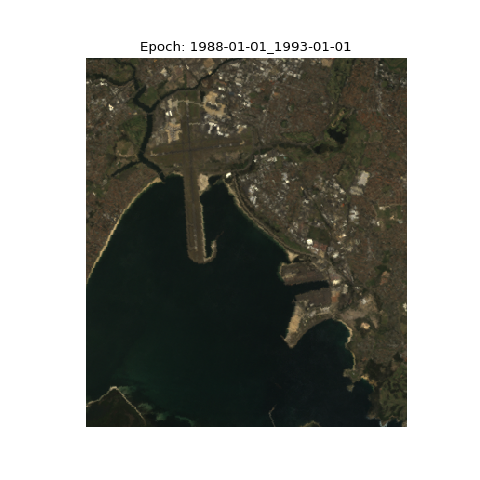

<IPython.core.display.Javascript object>


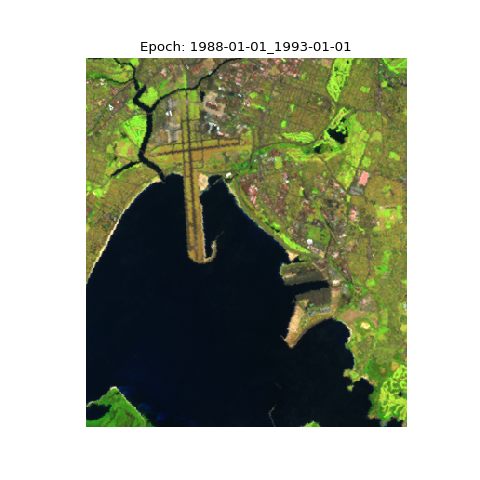

<IPython.core.display.Javascript object>


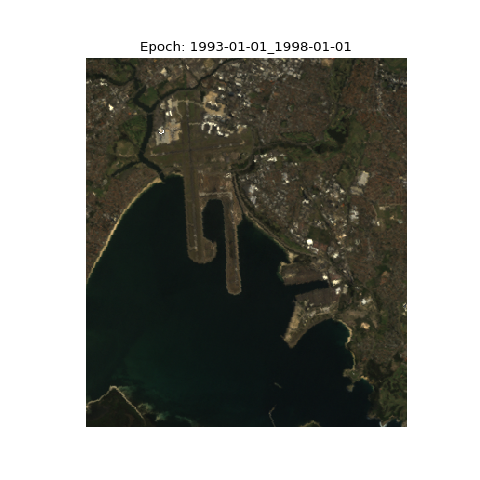

<IPython.core.display.Javascript object>


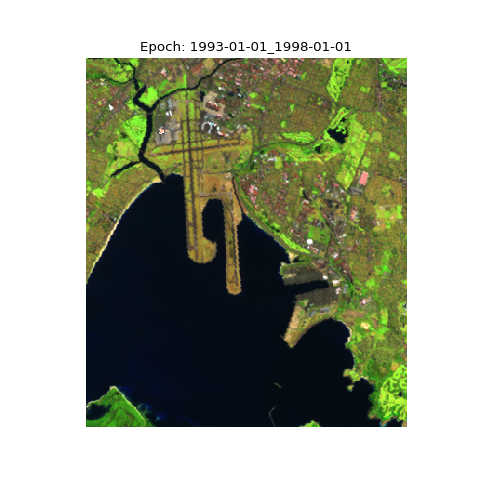

<IPython.core.display.Javascript object>


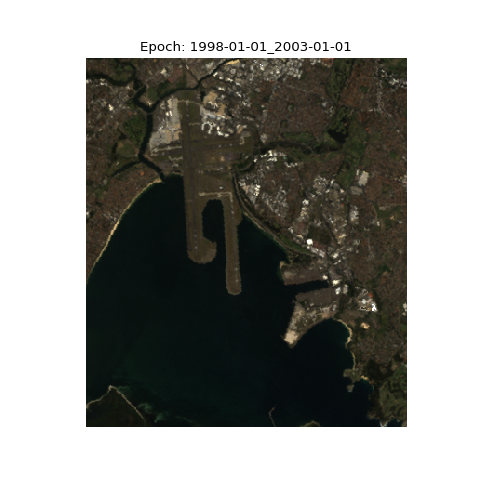

<IPython.core.display.Javascript object>


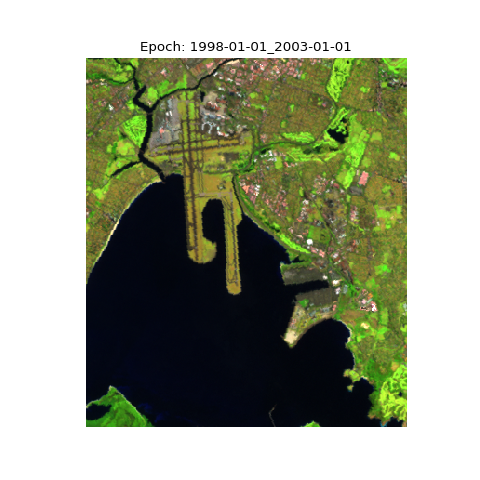

<IPython.core.display.Javascript object>


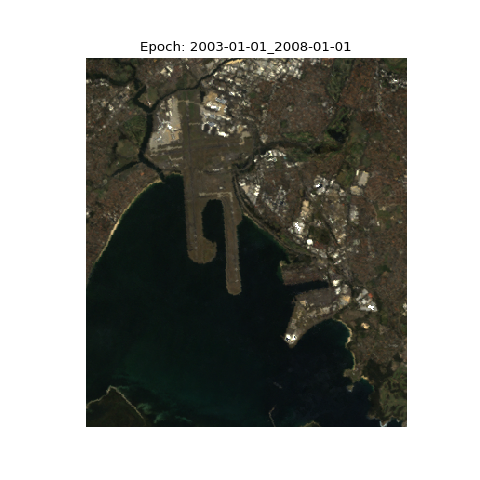

<IPython.core.display.Javascript object>


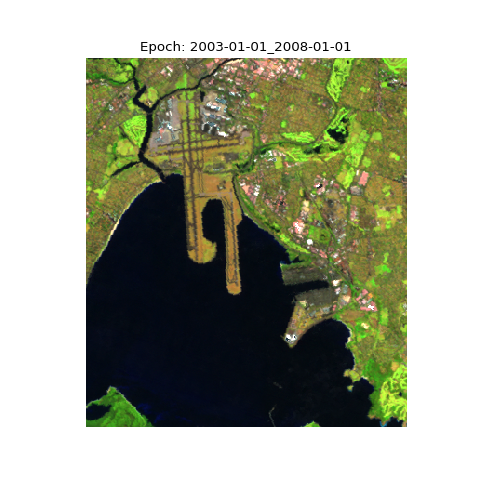

<IPython.core.display.Javascript object>


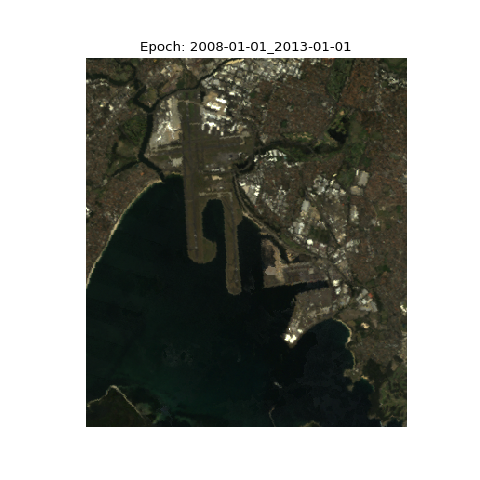

<IPython.core.display.Javascript object>


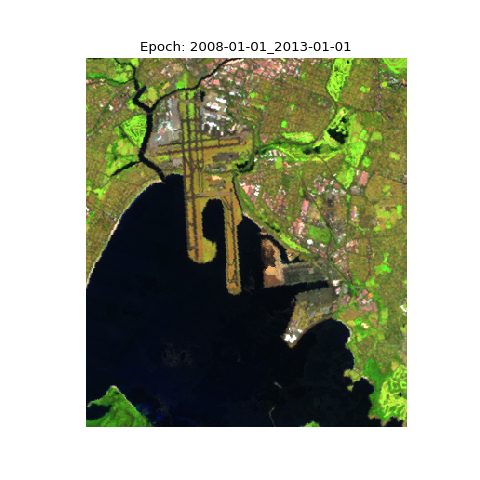

<IPython.core.display.Javascript object>


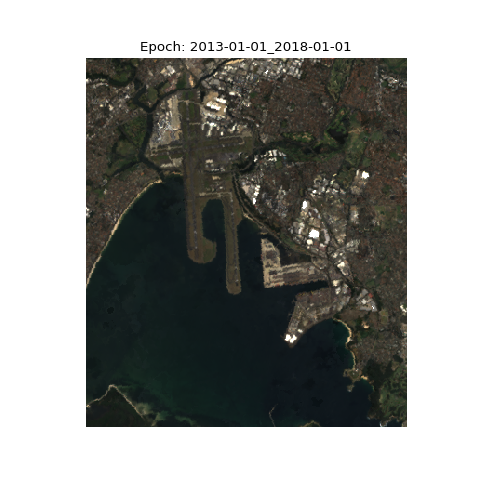

<IPython.core.display.Javascript object>


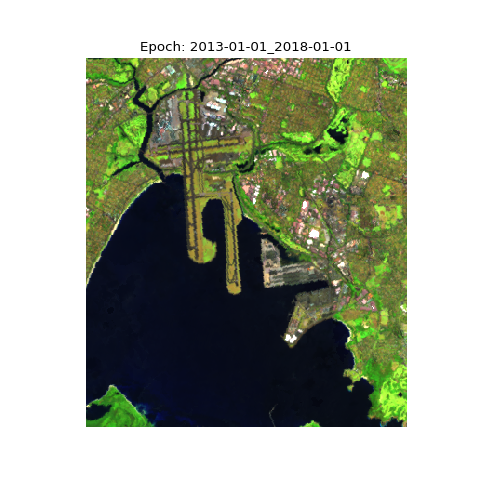

In [15]:
# PLOT COMPOSITES FOR EACH EPOCH

import rasterio
n = 0
fake_saturation = 4500
max_val = 0

# Geotiff settings for export
DEFAULT_PROFILE = {
    'blockxsize': 128,  # changed from 256
    'blockysize': 128,  # changed from 256 
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': nan,
    'tiled': True}

def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff
    :attr bands: ordered list of dataset names
    :attr time_index: time index to write to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes
    profile = DEFAULT_PROFILE.copy()
    profile.update({
                   'width': dataset.dims[dataset.crs.dimensions[1]],
                   'height': dataset.dims[dataset.crs.dimensions[0]],
                   'transform': dataset.affine,
                   'crs': dataset.crs.crs_str,
                   'count': len(dataset.data_vars),
                   'dtype': str(dtypes.pop())
    })
    profile.update(profile_override)
    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            dest.write(data.data, bandnum)

max_val = 4500

# for x in list:
for epoch_n, (k, gt) in enumerate(sorted(MY_GEO.items())):
    
    # create GeoTiff file
    flname= 'output_data/' + str(LOC) + '/' + str(LOC) + '_epoch_' + str(epoch_n) + '_lat_range_' + \
    str(lat_range) + "_lon_range_" + str(lon_range) + '_perc_tide_range_'+str(lower) + "_to_" + \
    str(upper) + "_" + k + "_.tif"
    write_geotiff(filename=flname, dataset=gt[['blue', 'green', 'red', 'nir', 'swir1', 'swir2']])
    
    # fix colors on true col geomedian   
    true_col = MY_GEO[k].to_array(dim='color').sel(color=['red', 'green', 'blue']).transpose('y', 'x', 'color')
    true_col_clipped_visible = true_col.where(true_col<fake_saturation).fillna(fake_saturation)
    true_col_scale_image = (true_col_clipped_visible / max_val) 
    
    # fix colors on false col geomedian
    false_col = MY_GEO[k].to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
    false_col_clipped_visible = false_col.where(false_col<fake_saturation).fillna(fake_saturation)
    false_col_scale_image = (false_col_clipped_visible / max_val)     
        
    # Plot true color composite, save to file and show
    fig = plt.figure(figsize=(6,6))
    gs1 = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs1[0])     
    ax1.imshow(true_col_scale_image, interpolation='nearest', aspect=None) 
    ax1.axis('off')
    plt.title("Epoch: "+ str(k))
    savefig('figures/' + str(LOC) + '/True_colour_'+str(LOC) + '_lat_range_' + str(lat_range) + \
            "_lon_range_"+ str(lon_range) + "_perc_range_" + str(lower) + "_to_" + str(upper) + \
            '_epoch_' + str(k) + "_.png", dpi = 300) 
    plt.show()   
    n=n+1
    
    # Plot false color composite and save to file 
    fig2 = plt.figure(figsize=(6,6))
    gs1 = GridSpec(1, 1)
    ax1 = fig2.add_subplot(gs1[0])     
    ax1.imshow(false_col_scale_image, interpolation='nearest', aspect=None) 
    ax1.axis('off')
    plt.title("Epoch: "+ str(k))
    savefig('figures/' + str(LOC) + '/False_colour_' + str(LOC) +'_lat_range_' + str(lat_range) + \
            "_lon_range_"+ str(lon_range) + "_perc_range_" + str(lower) + "_to_" + str(upper) + \
            '_epoch_' + str(k) + "_.png", dpi = 300) 
#     plt.close()


## Combine into filmstrip

Found 7 images


<IPython.core.display.Javascript object>


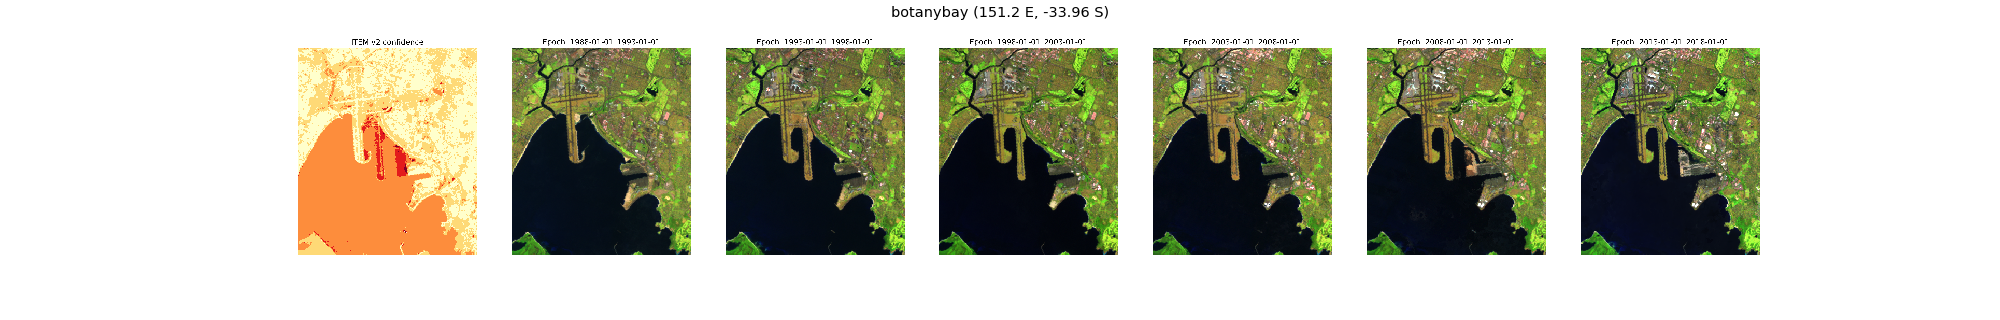

In [16]:
# %cd /g/data1/r78/cp7765/agdc_tidal/
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib.gridspec as gridspec

# Set up run
dirname="/g/data/r78/rt1527/intertidal/figures/"
# LOC = "fingalbay"
# colour_type = "True_colour"
colour_type = "False_colour"

# Find matching sites
filename = str(LOC) + '/' + colour_type + '_' + str(LOC) + '*.png'
per1 = glob.glob(dirname + filename)

# Find matching confidence layer
conf_filename = str(LOC) + '/ITEMv2_conf_' + str(LOC) + '*.png'
conf_match = glob.glob(dirname + conf_filename)

# Sort and return total images
per1 = sorted(per1)
per1 = conf_match + per1
print('Found ' + str(len(per1)) + ' images')

# Set up grid using number of images
gs1 = gridspec.GridSpec(1, len(per1), wspace=-0.200, hspace=-0.0)      #Update grid size (row,column)
fig = plt.figure(figsize=(25, 4))
# fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
plt.rcParams.update({'font.size':10})

#for fig in per1:
for y, n in enumerate(per1):
    name= 'ax'+ str(y+1)
    name=fig.add_subplot(gs1[y])
    name.axis('off')
    image=mpimg.imread(per1[y])
    name.imshow(image, aspect=None)

# Add overall figure title
fig.suptitle(str(LOC) + " (" + str(round(lon_point, 2)) + " E, " + str(round(lat_point, 2)) + " S)", fontsize=13)
fig.subplots_adjust(top=0.95)
   
# export to file
plt.savefig(dirname + '/' + str(LOC) + '/Filmstrip_' + colour_type + '_' + str(LOC) + '_Change_over_time.png',
           dpi = 300, bbox_inches='tight', pad_inches = 0) 
plt.show()

In [17]:
# Memory management test to reduce expanding runtimes
image = None
df2_model = None
tide_det = None
tides_model = None
tp_model = None
df2_index = None
model_index = None

import gc
gc.collect()

14552

## Create Hovmoller plots from composite datasets
To use this code, you must first upload a vector file of a transect line from which you wish the Hovmoller transect to be generated. Upload file above in section 1. In addition to generating a Hovmoller plot, a polygon is created around the transect from which geomedian composites can be produced using this notebook.

In [18]:
# ### PLOT A HOVMOLLER PLOT SHOWING THE TIDE-LIMITED DATA FOR THE EPOCH AND TIME-RANGE OF INTEREST###

# # create function definitions
# def geom_query(geom, geom_crs='EPSG:4326'):
#     """
#     Create datacube query snippet for geometry
#     """
#     return {
#         'x': (geom.bounds[0], geom.bounds[2]),
#         'y': (geom.bounds[1], geom.bounds[3]),
#         'crs': geom_crs
#     }


# def warp_geometry(geom, crs_crs, dst_crs):
#     """
#     warp geometry from crs_crs to dst_crs
#     """
#     return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


# def transect(data, geom, resolution, method='nearest', tolerance=None):
#     """
    
#     """
#     dist = [i for i in range(0, int(geom.length), resolution)]
#     points = list(zip(*[geom.interpolate(d).coords[0] for d in dist]))
#     indexers = {
#         data.crs.dimensions[0]: list(points[1]),
#         data.crs.dimensions[1]: list(points[0])        
#     }
#     return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
#                            method=method,
#                            tolerance=tolerance,
#                            **indexers)



# # Define additional variables of interest

# #Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
# bands_of_interest = [#'blue',
#                      'green',
#                      'red', 
#                      'nir',
#                      'swir1', 
#                      #'swir2'
#                      ]

# #Define sensors of interest
# sensors  = ['ls8','ls7','ls5']

# query = {'time': (time_range[0], time_range[1]),}
# query.update(geom_query(geom)) 
# query['crs'] = 'EPSG:4326'

# # Generate the tide-selected dataset for the epoch and time range of interest

# %run inter_tidal_data.py $LON $LAT $YEAR $HR $QT$tide_list$QT $EPOCH $DEB $LS7FL

In [19]:
# #Extract the hovmoller data volume

# for k,v in sorted(MY_GEO_HOVMOLLER.items()):  
#     crs = v.crs
    
# geom_w = warp_geometry(geom, query['crs'], crs.wkt)

# for k,v in sorted(MY_GEO_HOVMOLLER.items()):  
# #     crs = v.crs
# #     geom_w = warp_geometry(geom, query['crs'], crs.wkt)
#     hov = transect(v, geom_w, 25)
    
#     #Calculate NDVI ##Note: update here to change indice type e.g. NDVI, NDWI etc
# #     hov_ndvi = ((hov.nir-hov.red)/(hov.nir+hov.red))
#     hov_ndwi = ((hov.green-hov.nir)/(hov.green+hov.nir)) #NDWI calc after McFeeters, 1996

#     #Set up an NDVI colour ramp 
#     ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
#     ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
#     ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
    

#     #Set up an NDWI colour ramp 
#     ndwi_cmap = mpl.colors.ListedColormap(['#006600', '#009933', '#2eb82e', '#ccff66', '#ffffcc', '#ffcc66', 'blue'])
#     ndwi_bounds = [-1, -0.66, -0.33, 0.0, 0.25, 0.5, 0.75, 1]
#     ndwi_norm = mpl.colors.BoundaryNorm(ndwi_bounds, ndwi_cmap.N)    

#     #Generate the Hovmoller plot
#     fig = plt.figure()#figsize=(8.27,11.69))
# #     hov_ndvi.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
#     hov_ndwi.plot(x='distance', y='time', yincrease = False, cmap = ndwi_cmap, norm = ndwi_norm)
#     # savefig('/g/data/r78/cp7765/agdc_tidal/Hovmoller_all_data_ndwi' + site_name + str(lower)+'_to_'+str(upper)+ 'perc.png')

In [20]:
# # You'll notice that there are some rows that contain very few observations and make the plot harder to interpret
# # Set the percentage of good data that you'd like to display with pernan variable - 0.9 will return rows that have 90%
# # of valid values

# pernan = 0.85
# # hov_ndvi_drop = hov_ndvi.dropna('time',  thresh = int(pernan*hov.distance.size))
# hov_ndwi_drop = hov_ndwi.dropna('time',  thresh = int(pernan*hov.distance.size))
# fig = plt.figure()#figsize=()8.27,11.69))
# # hov_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
# hov_ndwi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndwi_cmap, norm = ndwi_norm)
# # savefig('/g/data/r78/cp7765/agdc_tidal/Hovmoller_'+ str(pernan)+'_perc_valid_data_' + site_name ++ str(lower)+'_to_'+str(upper)+ 'perc.png')
# print ('/g/data/r78/cp7765/agdc_tidal/Hovmoller_'+ str(pernan)+'_perc_valid_data_' + site_name + '.png')

# Interactive image output plot
## Generate interactive image output plot
No user input is required. Generate a composite input plot. Use the mouse to select a single observation by clicking on the plot. Run the following cells to view the observation corresponding to your selection on the plot.

In [21]:
# % pylab notebook
# import ipywidgets as widgets
# from IPython.display import display

# # Create the interactive widget

# w=widgets.HTML('Time and date of satellite observation will appear hear when point on graph is selected')

# def callback(event):
#     global time_date, tide_height, t_obs
#     t_obs = event
#     time_date = event.xdata
#     time_date = time_date.astype(datetime64[D])
#     tide_height = event.ydata
#     w.value = 'time_date: {}'.format(time_date)

# # Plot setup


# fig = plt.figure(figsize=(10,5))
# mpl.rcParams['agg.path.chunksize'] = 10000
# fig.canvas.mpl_connect('button_press_event', callback)
# # plt.legend(bbox_to_anchor=(0,-0.3), loc='center left')

# # plt.title('Image_source_' + LOC + '_' + str(EPOCH).split()[1] + '_year_epoch_' + str(PER).split(' ')[1] + \
# # '_percentile')


# # Plot data

# # Add scatter plot for all observations
# scatter(obstiderangeepoch_plotdates, df4_obs_tide_range.Tide_height, marker="o", color="red", \
#             zorder=8, label="Composite observations")
# # scatter(df_e_index, df_e.Tide_height, s=20, color='gray', marker='o', zorder=2, label = 'All observations')
# # scatter(df_f_index, df_f.Tide_height, s=20, color='gray', marker='o', zorder=3, label = None)
# # scatter(df_ph_index, df_ph.Tide_height, s=20, color='gray', marker='o', zorder=4, label = None)
# # scatter(df_pl_index, df_pl.Tide_height, s=35, color='gray', marker='o', zorder=5, label = None)

# # Add line plot for OTPS tide heights
# # plot(model_index, df2_model.Model_height, color='lightgray', linewidth=0.5, zorder=1, label = 'OTPS model')

# # Add percentile range lines to show where composite observations were collected

# # plot([obs_index[0],obs_index[-1]], [uppertide, uppertide], 'black', zorder=3, label = 'upper' + PERCC + '%ile_obs')
# # plot([obs_index[0],obs_index[-1]], [lowertide, lowertide], 'darkblue', zorder=4, label = 'lower' + PERCC + '%ile_obs')

# # Show each epoch

# # a=10
# # b=0
# # for date in epoch_list_datetime:
# #     plot([epoch_list_datetime[b], epoch_list_datetime[b]], [df_per10.PERC_tide_height[0], \
# #         df_per10.PERC_tide_height[100]], 'black',linewidth=0.5, zorder=a)
# #     a=a+1
# #     b=b+1

# # Show percentile ranges of observations
# # for i in per10_list:
# #     plot([model_index[0], model_index[-1]], [df_per10.PERC_tide_height[i],df_per10.PERC_tide_height[i]], 'black', \
# #          linewidth=0.4)# , label= str(a) + 'th %ile of obs')
# #     plt.text(model_index[-1] + 100, i[1] - 0.025, str(i[0])+'th %ile', fontsize=8)
    
# # Save and show plot
# # plt.savefig('Image_source_' + LOC+ '_' +Latrangein+'_'+Longrangein+'_'+str(EPOCH).split()[1] + '_year_epoch_' + str(PER).split(' ')[1] + \
# # '_percentile_' + k + ".jpg")    

# # fig.axes.Axes.set_xlim([datetime.date(time_range[0])], datetime.date(time_range[1]))
# # fig.set_xlim([datetime.date(time_range[0]), datetime.date(time_range[1])])
    
# print (w.value)
# plt.show() 
# display (w) 


## Select point on plot to search for associated image

After selecting an observation from the plot by clicking a point with the mouse, run the following cells to find and view the image. 
Note, due to the nature of matplotlib inline, each new plot selection requires the figure above to be re-produced (just run the plot generation cell only)
Note 2, this code looks for an observation within 5 days either side of your mouse selection. This range can be changed on lines 11 and 12. Remember that Landsat passes occur every 16ish days so keep this in mind when setting this threshold.
This cell tells you whether an observation exists for your date/time selection on the plot.

In [22]:
# time_slice = str(matplotlib.dates.num2date(time_date).date())
# #time_slice=str(time_slice)
# #print time_slice
# time_slice= str(pd.to_datetime(time_slice, format='%Y-%m-%d'))
# # print time_slice
# # time_slice= str(time_slice)
# # print time_slice
# time_slice_actual=datetime.datetime.strptime(time_slice,'%Y-%m-%d  %H:%M:%S')
# # time_slice_actual=time_slice
# # print time_slice_actual
# time_slice_t1=time_slice_actual+datetime.timedelta(days=-5)
# time_slice_t2=time_slice_actual+datetime.timedelta(days=5)



# print ('date_of_observation_selection_on_interactive_plot: ' + str(time_date)) # This value comes from the button click on the interactive plot above
# print ('Selected observation date: ' +str(time_slice_actual))
# print ('Time 1:' +str(time_slice_t1))
# print ('Time 2: ' +str(time_slice_t2))
 

## Build data array and view imagery

Run the cell below to visualise the observation associated with your mouse selection. Note that a loop needs to be written to search through all three Landsat sensors. For the time being, if you don't view your observation initially but the above cell indicates that an observation was recorded, edit line 7 below to change sensor (ls5, ls7 or ls8).
This cell will build a data array based on the discovery of a valid observation from the cell above.

In [23]:
# # Find the observation in the datacube archive represented by a mouse click selection on the interactive plot

# import datacube

# dc = datacube.Datacube(app='inter_habitat_interactive')

# obs_nbar = dc.load(product= 'ls8_nbar_albers', x=(float(lon_range.split(",")[0].split('(')[-1]), float(lon_range.split(",")[-1].split(')')[0])), y=(float(lat_range.split(",")[0].split('(')[-1]),\
#                     float(lat_range.split(",")[-1].split(')')[0])), time=((str(time_slice_t1)).split(' ')[0], (str(time_slice_t2)).split(' ')[0]))

# obs_nbar = obs_nbar.astype('float32')
# # print (obs_nbar) #If no dataset is returned, resample the interactive plot. Due to the extended timeline of the plot, \
# #a click may miss the actual observation. Note, locations are sampled every 16 days on average so the archive is searched\
# #+/- 10 days each side of your selection on the interactive plot to try and catch the observation you want to view.

# #Prepare imagery

# rgb =obs_nbar.sel(time =time_slice_actual, method = 'nearest').to_array(dim='color').sel(color=['swir1','nir', 'green'])\
# .transpose('y', 'x', 'color')
# # fake_saturation = 6000.0
# fake_saturation = 4500.0
# rgb = rgb.astype('double')
# clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation) # clip rgb to fake_saturation or less
# #clipped_visible = rgb.where(rgb<fake_saturation, other=fake_saturation) # clip rgb to fake_saturation or less
# #clipped_visible = clipped_visible.where(rgb>0, other=0) # zero -999 nodata (in fact, zero anything that isn't positive)
# clipped_visible = clipped_visible.where(rgb>0).fillna(0) # zero -999 nodata (in fact, zero anything that isn't positive)
# max_val = clipped_visible.max(['y', 'x'])
# scaled = (clipped_visible / max_val)

# print (scaled.coords)
# print ()
# print( "complete " +str(datetime.datetime.now()))

# plt.close('all')
# print (scaled.time.coords)
# plt.imshow(scaled.data)
# plt.axis('off')

## Determine modelled tide height associated with image

Insert the date from the 'time' coordinate of the data array below (line 1) to find the modelled tide height associated with the output image.

The commented out code below used to do the same thing without the hard coding but needs de-bugging.

In [24]:
# print (df4_obs_tide_range.loc['2016-02-07'])

# # # Determine the tide height for the desired observation by comparing the observation date with the tide-tagged observation
# # # archive (from dict DATETIME, generated in extract_tidal_datelist.py)
# # n=0
# # for value in DATETIDE.values()[0]:
# #     if DATETIDE.values()[0][n][0] == str(obs_nbar.time.values[0].astype('datetime64[D]')):
# #         tideheight = DATETIDE.values()[0][n][1]
# #         break
# #     n=n+1

# # print ("Observation date: "+str(obs_nbar.time.values[0].astype('datetime64[D]')))
# # print ('Confirm: ' +str(DATETIDE.values()[0][n])    )
# # print( 'Tide height: ' +str(tideheight))
# # print ("The tideheight was " +str(tideheight) +" m on " +str(time_slice_actual) +" at " +str(LOC)) 

## Save individual image as geotiff

Save your single observation as a 6 band geotiff. No inputs required except an update of the output file location in line 21

In [25]:
# import rasterio



# ###PLOT AS GEOTIFF
# # Creating a GeoTiff file


# DEFAULT_PROFILE = {
# 'blockxsize': 256,
# 'blockysize': 256,
# 'compress': 'lzw',
# 'driver': 'GTiff',
# 'interleave': 'band',
# 'nodata': nan,
# 'tiled': True}


# gt = (obs_nbar.sel(time =time_slice_actual, method = 'nearest'))
# print (gt.time.coords.values)
# flname="/g/data/r78/rt1527/"+LOC+'_lon_range_'+lon_range+'_lat_range_'+lat_range+'_'+\
#     str(gt.time.coords.values).split('[ns] ')[-1]+"_.tif"


# def write_geotiff(filename, dataset, time_index=None, profile_override=None):
#     """
#     Write an xarray dataset to a geotiff
#     :attr bands: ordered list of dataset names
#     :attr time_index: time index to write to file
#     :attr dataset: xarray dataset containing multiple bands to write to file
#     :attr profile_override: option dict, overrides rasterio file creation options.
#     """
#     profile_override = profile_override or {}

#     dtypes = {val.dtype for val in dataset.data_vars.values()}
#     assert len(dtypes) == 1  # Check for multiple dtypes
#     profile = DEFAULT_PROFILE.copy()
#     profile.update({
#                    'width': dataset.dims[dataset.crs.dimensions[1]],
#                    'height': dataset.dims[dataset.crs.dimensions[0]],
#                    'transform': dataset.affine,
#                    'crs': dataset.crs.crs_str,
#                    'count': len(dataset.data_vars),
#                    'dtype': str(dtypes.pop())
#     })
#     profile.update(profile_override)
#     with rasterio.open(filename, 'w', **profile) as dest:
#         for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
#             dest.write(data.data, bandnum)


# write_geotiff(filename=flname, dataset=gt[['blue', 'green', 'red', 'nir', 'swir1', 'swir2']])
# print (flname)
# print ()
# print ('Complete '+str(datetime.datetime.now()))